In [1]:
'''
Hao Fu
This code reproduces plots from output of STEEL (Grylls P. et al 2019).
Some functions are taken from previous scripts.
Follow the instruction in STEEL/ReadMe.md to install Functions.
'''

import numpy as np
import os
import sys
import numpy.ma as ma
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d
import matplotlib as mpl
#mpl.use('agg')
import matplotlib.pyplot as plt
import matplotlib.ticker as tik
from Functions import *
from Functions import Functions as F #Hao
import SDSS_Plots
from colossus.cosmology import cosmology
from itertools import cycle
from statsmodels.stats.weightstats import DescrStatsW
from scipy import optimize
from scipy.interpolate import interp1d
cosmology.setCosmology("planck15")
Cosmo =cosmology.getCurrent()
h = Cosmo.h
h_3 = h*h*h
#Add_SDSS = SDSS_Plots.SDSS_Plots(11.5,15,0.1) #pass this halomass:min, max, and binwidth for amting the SDSS plots


f_tau_str = "$f_{tdyn}$"

'''
#set plot paramaters here
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'font.size': 15})
mpl.rcParams.update({'lines.linewidth': 2})
mpl.rcParams.update({'lines.markersize': 5})
DPI = 200
'''


#gets the HMF interpolation function
HMF_fun = F.Make_HMF_Interp()

######### Parameters assumption for central

#Abundance Matching Parameters
Override =\
{\
'M10':12.0,\
'SHMnorm10':0.032,\
'beta10':1.5,\
'gamma10':0.56,\
'M11':0.6,\
'SHMnorm11':-0.014,\
'beta11':-2,\
'gamma11':0.08\
}


AbnMtch =\
{\
'Behroozi13': False,\
'Behroozi18': False,\
#'Behroozi19': True,\
'B18c':False,\
'B18t':False,\
'G18':False,\
'G18_notSE':False,\
'G19_SE':True,\
'G19_cMod':False,\
'Lorenzo18':False,\
'Moster': False,\
'Moster10': False,\
'Illustris': False,\
'z_Evo':True,\
'Scatter': 0.15,\
'Override_0': False,\
'Override_z': False,\
'Override': Override,\
'PFT': False,\
'M_PFT1': False,\
'M_PFT2': False,\
'M_PFT3': False,\
'N_PFT1': False,\
'N_PFT2': False,\
'N_PFT3': False,\
'b_PFT1': False,\
'b_PFT2': False,\
'b_PFT3': False,\
'g_PFT1': False,\
'g_PFT2': False,\
'g_PFT3': False,\
'g_PFT4': False,\
'HMevo': False,\
'HMevo_param': None\
}

Paramaters_Glob = \
{\
'AbnMtch' : AbnMtch,\
'AltDynamicalTime': 1,\
'NormRnd': 0.5,\
'SFR_Model': 'CE',\
'PreProcessing': False,\
'AltDynamicalTimeB': False\
}

#'''
#macc/M0
Unevolved = {\
'gamma' : 0.22,\
'alpha' : -0.91,\
'beta' : 6,\
'omega' : 3,\
'a' : 1,\
}
#'''


In [2]:
print(h)

0.6774


In [2]:
#===============================Functions definition==================================


#### Gaussian
def Gaussian(x,m,s,A):
    return A* np.exp( - (x-m)**2 / (2.*s**2)) / s


#Create figure folder with name from Running parameters and returns directory path
def create_folder(Tdyn_Factors):
    dir_path = '../../Figures/' #Path to save
    for RunParam in Tdyn_Factors: #define plots folder name
        dir_path = dir_path+"RunParam_{}".format("".join(("{}_".format(i) for i in RunParam)))
    if (os.path.isdir(dir_path) == True): #if present, delete old folder with same name
        os.system('rm -r '+dir_path)
    os.system('mkdir '+dir_path) #create folder
    return dir_path


#### Identify index of a desired redshift value
def identify_idx_z(z_desired, z):
    if (z_desired == 0.):
        z_idx=0
    elif (z_desired > 0. and z_desired < np.max(z)):
        for i in range(0,z.size):
            if (z[i]>z_desired):
                z_idx=i
                break
        z2=z[z_idx]; z1=z[z_idx-1]
        diff1=np.abs(z1-z_desired)
        diff2=np.abs(z2-z_desired)
        if (diff1<=diff2):
            z_idx=z_idx-1
    #elif (z_desired == 6.):
        #z_idx=z.size-1
    elif (z_desired > np.max(z)):
        Err_msg = 'The desired value {} in z_desired is larger than the maximum value in z!\nCannot identify z index!'.format(z_desired)
        sys.exit(Err_msg)
    return z_idx


#### Build the list of desired redshifts
def build_z_desired(z_min, z_max, z_bin):
    z_desired = []
    z_prova = z_min
    z_desired.append(z_prova)
    while True:
        z_prova += z_bin
        if (z_prova>z_max):
            break
        z_desired.append(z_prova)
    return z_desired


#Initialize variables for SMHM loop
#Same for all redshifts
def SMHM_var_init(Surviving_Sat_SMF_MassRange, SatHaloMass):
    SM = Surviving_Sat_SMF_MassRange
    SMHM = np.zeros(SatHaloMass.size+1)
    HM_bin=SatHaloMass[1]-SatHaloMass[0] 
    HM = np.zeros(SatHaloMass.size+1)
    HM[0] = SatHaloMass[0]-HM_bin
    for i in range(0, SatHaloMass.size+1):
        if (i>0):
            HM[i]=HM[i-1]+HM_bin
    return SM, HM, SMHM


#Plot SM distributions
def plot_SM_distrib(z_idx, SatHaloMass, SM, Sat_SMHM):
    plt.figure()
    #plt.plot(x,y,'.')
    for i in range(0, SatHaloMass.size+1):
        plt.semilogy(SM,Sat_SMHM[z_idx,i,:])
    #plt.figure()
    #plt.xlim(9,13)
    #for i in range(0, SM.size):
    #    plt.semilogy(SM[i],np.max(Sat_SMHM[z_idx,i,:]),'o',color='steelblue')
    return


#Loops over halo masses with cumulative function
def loop_HM_cumu(z_idx, SM, SMHM, SatHaloMass, Sat_SMHM, Num_points):
    #sm = array of SM bins
    sm=np.zeros(SM.size-1)
    for i in range(0,SM.size-1):
        sm[i]=SM[i]+(SM[1]-SM[0])/2.
    res=np.zeros(SatHaloMass.size+1) #initialize array of residuals of cumulative half value

    #begin loop over halo masses
    #fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    for j in range(SatHaloMass.size+1):
        cum=cumtrapz(Sat_SMHM[z_idx,j,:],SM) #calculate cumulative function of SM distributions
        cumu=interp1d(sm,cum) #interpolate cumulative functions
        #Num_points=3000 #define number of points for linspace
        lin=np.linspace(np.min(sm),np.max(sm),Num_points) #generate linspace
        half=np.max(cumu(lin))/2. #cumulative half value
        idx=0 #initialize index
        diff=np.zeros(Num_points) #arrays used to test tollerace of difference
        min=1.e10 #initialize the min diff with a number randomly large
        percent=0.05 #define stop of the loop over linspace
        for i in range(0,Num_points): #loop over linspace
            if (cumu(lin)[i]>(half)*(1.-percent)):
                diff[i]=np.abs(half-cumu(lin)[i])
                if(diff[i]<min):
                    min=diff[i]
                    idx=i
            if (cumu(lin)[i]>(half)*(1.+percent)): #exit loop over linspace
                break
        res[j]=np.abs(cumu(lin)[idx]-half) #calculate residuals
        #plt.figure(2)
        #if (SatHaloMass[j-1]>14.):
            #print(Sat_SMHM[z_idx,j-1,:])
        #ax[0].plot(lin,cumu(lin)) #plot cumulatives
        #ax[0].hlines(cumu(lin[idx]),np.min(sm),np.max(sm)) #plot half cumulatives
        SMHM[j]=lin[idx] #allocate SMHM relation
        #print(j)

    #plt.figure(2)
    #ax[0].set_xlabel(r'log$_{10} M_* [M_\odot]$')
    #ax[0].set_xlim(9,12.5)
    
    #plt.figure(3)
    #ax[1].plot(HM,res,'o')
    #ax[1].set_xlabel(r'log$_{10} M_h [M_\odot]$')
    #ax[1].set_ylabel(r'Half cumulative residuals')
    #ax[1].set_xlim(11,15)
    
    return SMHM


In [4]:
#Calculate satellite SMHM

In [3]:
#Set running parameters and read model data

Tdyn_Factors = [('1.0', False, False, True, 'CE', 'G19_SE')] #Running parameters
#Tdyn_Factors = [('1.0', True, False, True, 'CE', 'G19_SE')]
#Tdyn_Factors = [('1.0', False, True, True, 'CE', 'G19_SE')]
#Tdyn_Factors = [('1.0', True, True, True, 'CE', 'G19_SE')]

In [4]:
#dir_path = create_folder(Tdyn_Factors)
dir_path = '../../Figures/My_outputs'

In [4]:
def DarkMatterToStellarMass_Alt(DarkMatter, Redshift, Paramaters, ScatterOn = False, Scatter = 0.001):
    np.random.seed()
    Paramaters = Paramaters['AbnMtch']
    z = Redshift
    if(Paramaters['Behroozi18']):
        if(Paramaters['B18c']):
            """e = np.array([-1.480, 0.693, 0.042, 0.121])
            M = np.array([12.004, 2.220,2.229,-0.363])
            alpha = np.array([2.041,-1.276,-1.082,0.147])
            beta = np.array([0.500,-0.219,-0.168,0.305])
            gamma = np.array([-0.848,-2.115,-0.664])
            delta = 0.350"""
            e = np.array([-1.340,0.404,-0.048,0.133])
            M = np.array([12.027,2.582,2.594,-0.409])
            alpha = np.array([1.999,-1.710,-1.393,0.192])
            beta = np.array([0.502,-0.267,-0.197])
            gamma = np.array([-0.788,-1.947,-0.658])
            delta = 0.340
        elif(Paramaters['B18t']):
            """e = np.array([-1.505,0.607,0.002,0.124])         
            M = np.array([11.979,2.293,2.393,-0.380])
            alpha = np.array([1.998,-1.394,-1.175,0.166])
            beta = np.array([0.512,-0.181,-0.160])
            gamma = np.array([-0.738,-1.697,-0.573])
            delta = 0.382"""
            e = np.array([-1.357,0.139,-0.230,0.157])
            M = np.array([11.968,2.231,2.359,-0.374])
            alpha = np.array([2.025,-1.365,-1.174,0.167])
            beta = np.array([0.520,-0.135,-0.161])
            gamma = np.array([-0.729,-1.764,-0.639])
            delta = 0.351

        a      = 1/(1+Redshift)
        afac   = a-1


        log10_M  = M[0]     + (M[1]*afac)     - (M[2]*np.log(a))     + (M[3]*z)
        e_       = e[0]     + (e[1]*afac)     - (e[2]*np.log(a))     + (e[3]*z)
        alpha_   = alpha[0] + (alpha[1]*afac) - (alpha[2]*np.log(a)) + (alpha[3]*z)
        beta_    = beta[0]  + (beta[1]*afac)                         + (beta[2]*z)
        log10_g  = gamma[0] + (gamma[1]*afac)                        + (gamma[2]*z)

        
        #print(DarkMatter.shape)
        #print(log10_M.shape)
        x = DarkMatter-log10_M
        gamma_ = np.power(10, log10_g)

        Part1 = np.log10(np.power(10, -alpha_*x) + np.power(10, -beta_*x))
        Part2 = np.exp(-0.5*np.power(np.divide(x, delta), 2))
        M_Star = log10_M+(e_ - Part1 + gamma_*Part2)


        if ScatterOn:
            Scatter = np.random.normal(scale = Scatter, size = np.shape(M_Star))
            return M_Star + Scatter
        else:
            return M_Star
                        
    elif Paramaters['Behroozi13'] or Paramaters['Lorenzo18']:
        if(Paramaters['Behroozi13']):
            e = np.array([-1.777, -0.006, 0.000, -0.119])
            M = np.array([11.514,-1.793,-0.251])
            alpha = np.array([-1.412,0.731])
            delta = np.array([3.508,2.608,-0.043])
            gamma_b = np.array([0.361,1.391,0.279])
            ep = np.array([0.218,-0.023])
        if(Paramaters['Lorenzo18']):
            e = np.array([-1.6695, -0.006, 0.000, -0.119])
            M = np.array([11.6097,-1.793,-0.251])
            alpha = np.array([-1.998,0.731])
            delta = np.array([3.2108,2.608,-0.043])
            gamma_b = np.array([0.4222,1.391,0.279])
            ep = np.array([0.1346,-0.023])
        a      = 1/(1+Redshift)
        afac   = a-1
        v_     = np.exp(-4*np.power(a,2))
        M_     = M[0]       + (M[1]      *afac +M[2]*z      )*v_
        e_     = e[0]       + (e[1]      *afac +e[2]*z      )*v_ + e[3]*afac
        alpha_ = alpha[0]   + (alpha[1]  *afac              )*v_
        delta_ = delta[0]   + (delta[1]  *afac +delta[2]*z  )*v_
        gamma_ = gamma_b[0] + (gamma_b[1]*afac +gamma_b[2]*z)*v_
        ep_    = ep[0]      + (ep[1]*afac                   )


        e_ = np.power(10, e_)
        M_ = np.power(10, M_)

        def f(x, a = alpha_, d = delta_, g = gamma_):
            Part1 = np.log10(np.power(10, a*x) + 1)
            Part2 = np.power(np.log10(1+np.exp(x)),g)
            Part3 = 1 + np.exp(np.power(10, -x))
            return -Part1 + d*np.divide(Part2, Part3)

        Part1 = np.log10(e_*M_)
        Part2 = f( np.log10( np.divide(np.power(10,DarkMatter), M_) ) )
        Part3 = f(0)

        M_Star = Part1 + Part2 - Part3
        Scatter = np.random.normal(scale = Scatter, size = np.shape(M_Star))
        if ScatterOn:
            return M_Star + Scatter
        else:
            return M_Star

In [14]:
Tdyn_Factors = [('1.0', False, False, True, 'CE', 'G19_SE')] #Running parameters
#Tdyn_Factors = [('1.0', True, False, True, 'CE', 'G19_SE')]
#Tdyn_Factors = [('1.0', False, True, True, 'CE', 'G19_SE')]
#Tdyn_Factors = [('1.0', True, True, True, 'CE', 'G19_SE')]

'''
AvaHaloMass, SMF, Surviving_Sat_SMF_MassRange, z = F.LoadData_SMFhz(Tdyn_Factors)
print(np.shape(AvaHaloMass))
print(np.shape(SMF))
print(np.shape(Surviving_Sat_SMF_MassRange))
print(np.shape(z))
'''

Surviving_Sat_SMF_MassRange, sSFR_Range, Satellite_sSFR = F.LoadData_sSFR(Tdyn_Factors)
print(np.shape(Surviving_Sat_SMF_MassRange))
print(np.shape(sSFR_Range))
print(np.shape(Satellite_sSFR))
print(sSFR_Range)

(40,)
(59,)
(40, 59)
[-14.  -13.9 -13.8 -13.7 -13.6 -13.5 -13.4 -13.3 -13.2 -13.1 -13.  -12.9
 -12.8 -12.7 -12.6 -12.5 -12.4 -12.3 -12.2 -12.1 -12.  -11.9 -11.8 -11.7
 -11.6 -11.5 -11.4 -11.3 -11.2 -11.1 -11.  -10.9 -10.8 -10.7 -10.6 -10.5
 -10.4 -10.3 -10.2 -10.1 -10.   -9.9  -9.8  -9.7  -9.6  -9.5  -9.4  -9.3
  -9.2  -9.1  -9.   -8.9  -8.8  -8.7  -8.6  -8.5  -8.4  -8.3  -8.2]


In [15]:
#load data for satellite SMHM
z, SatHaloMass, AvaHaloMass, Surviving_Sat_SMF_MassRange, Sat_SMHM, Sat_SMHM_Host = F.LoadData_Sat_SMHM(Tdyn_Factors) #read model data from output folder
print(np.shape(SatHaloMass))
print(np.shape(AvaHaloMass))
print(np.shape(Sat_SMHM))
print(np.shape(Surviving_Sat_SMF_MassRange))

(65,)
(190, 57)
(190, 66, 40)
(40,)


In [19]:
#for i, HM_Arr in enumerate(AvaHaloMass):
    #print(i)
    #print(HM_Arr); print(AvaHaloMass[i,:])

SyntaxError: unexpected EOF while parsing (<ipython-input-19-12c4160859e2>, line 3)

In [7]:
HighRes = False
#HaloMass Limits and Bins
AnalyticHaloMass_min = 11.0; AnalyticHaloMass_max = 16.6
if HighRes:
    AnalyticHaloBin = 0.05
else:
    AnalyticHaloBin = 0.1
#AHB_2 = AnalyticHaloBin*AnalyticHaloBin #Not used
AnalyticHaloMass = np.arange(AnalyticHaloMass_min + np.log10(h), AnalyticHaloMass_max + np.log10(h), AnalyticHaloBin) #Create array in the Halo Mass range
#Units are in M_virial * h^-1
#Read https://arxiv.org/abs/1308.4150

#This is the Halomass growth history
#Generates redshfit steps that are small enough to avoid systematics.
z, AvaHaloMass_wz = F.Get_HM_History(AnalyticHaloMass, AnalyticHaloMass_min, AnalyticHaloMass_max, AnalyticHaloBin)
AvaHaloMass = AvaHaloMass_wz[:, 1:] #Avarage Halo Mass for each redshift (M,N), units of [log10 Msun]

#DM=np.transpose(AvaHaloMass)
DM=AvaHaloMass
print(np.shape(DM))

(190, 57)


In [8]:
#Load data for central SMHM relation
Paramaters = Paramaters_Glob
DM = np.arange(11.,15., 0.1)
SM_cen = F.DarkMatterToStellarMass(DM, z, Paramaters, ScatterOn = False, Scatter = 0.001, Pairwise = True)
#print(z)

sono qui


In [11]:
AbnMtch['Behroozi18'] = False
AbnMtch['B18c'] = False
AbnMtch['B18t'] = False
AbnMtch['G19_SE'] = True
Paramaters = Paramaters_Glob
DM = np.arange(11.,15., 0.1)
SM_cen = F.DarkMatterToStellarMass(DM, z, Paramaters, ScatterOn = False, Scatter = 0.001, Pairwise = True)

In [5]:
#print(DM.shape)
#print(SM_cen.shape)
#print(DM)

######Grylls
AbnMtch['Behroozi18'] = False
AbnMtch['B18c'] = False
AbnMtch['B18t'] = False
AbnMtch['G19_SE'] = True
Paramaters = Paramaters_Glob
#DM = np.arange(11.,15., 0.1)
SM_cen = F.DarkMatterToStellarMass(DM, z, Paramaters, ScatterOn = False, Scatter = 0.001, Pairwise = False)

print(np.shape(SM_cen))

SM_central=np.zeros(z.size)
for i in range(0,z.size):
    SM_central[i]=np.mean(SM_cen[i,:])

plt.figure()
plt.semilogx(z,SM_cen[:,10])


######Behroozi
AbnMtch['Behroozi18'] = True
AbnMtch['B18c'] = True
AbnMtch['B18t'] = False
AbnMtch['G19_SE'] = False
Paramaters = Paramaters_Glob
#DM = np.arange(11.,15., 0.1)
#DM = 12.
#SM_cen = DarkMatterToStellarMass_Alt(DM, z, Paramaters, ScatterOn = False, Scatter = 0.001)

print(np.shape(SM_cen))
#plt.semilogx(z,SM_cen[:],label='Behroozi')
#plt.xlim(0.1,4)
#plt.ylim(9.5,11.5)
#plt.legend()

ValueError: operands could not be broadcast together with shapes (190,57) (190,) 

In [197]:
'''
for z_des in z_desired:
    z_idx = identify_idx_z(z_des, z)
    plot_SM_distrib(z_idx, SatHaloMass, SM, Sat_SMHM)
'''

'\nfor z_des in z_desired:\n    z_idx = identify_idx_z(z_des, z)\n    plot_SM_distrib(z_idx, SatHaloMass, SM, Sat_SMHM)\n'

In [101]:
#Loop on halo masses with Gaussian fit (doesn't work)
'''
for i in range(0, SatHaloMass.size+1):
    print(i)
    popt, pcov = cf(Gaussian, SM, Sat_SMHM[0,i,:])
    SMHM[i] = popt[0]
    plt.plot(np.linspace(9,13,1000),Gaussian(np.linspace(9,13,1000),popt[0],popt[1],popt[2]),'black')
    if (i>0):
        HM[i]=HM[i-1]+HM_bin
'''

"\nfor i in range(0, SatHaloMass.size+1):\n    print(i)\n    popt, pcov = cf(Gaussian, SM, Sat_SMHM[0,i,:])\n    SMHM[i] = popt[0]\n    plt.plot(np.linspace(9,13,1000),Gaussian(np.linspace(9,13,1000),popt[0],popt[1],popt[2]),'black')\n    if (i>0):\n        HM[i]=HM[i-1]+HM_bin\n"

Running z = 0.0
Running z = 0.5
Running z = 1.0
Running z = 1.5
Running z = 2.0
Running z = 2.5
Running z = 3.0


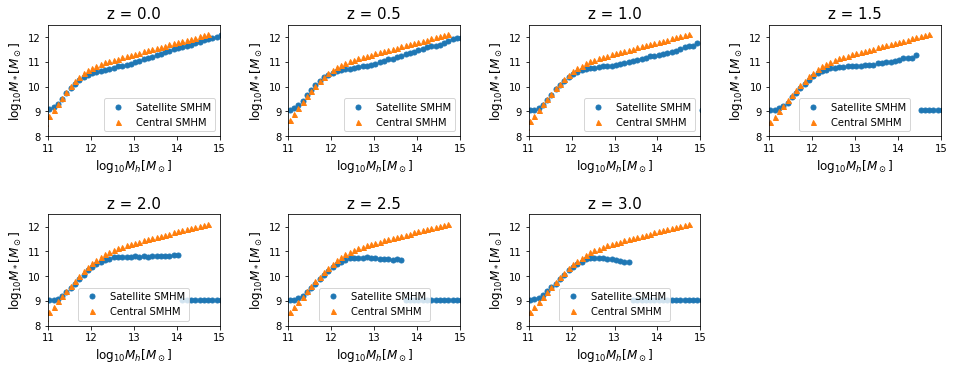

In [17]:
#Plot SMHM relations

#Initialize some variables
SM, HM, SMHM = SMHM_var_init(Surviving_Sat_SMF_MassRange, SatHaloMass)
z_desired = build_z_desired(z_min=0., z_max=3., z_bin=0.5)

N_rows=5
N_cols=4
fig1, ax1 = plt.subplots(N_rows, N_cols, figsize=(16, 16))
plt.subplots_adjust(wspace=0.4, hspace=0.7)
rows_idx=0
cols_idx=0
for z_des in z_desired:
    print('Running z = {:0.1f}'.format(z_des))
    z_idx = identify_idx_z(z_des, z)
    SMHM = np.zeros(SatHaloMass.size+1)
    SMHM = loop_HM_cumu(z_idx, SM, SMHM, SatHaloMass , Sat_SMHM, Num_points=100)
    #print(SMHM)
    ax1[rows_idx,cols_idx].plot(HM,SMHM, 'o', label='Satellite SMHM')
    ax1[rows_idx,cols_idx].plot(DM + np.log10(h), SM_cen[z_idx], '^', label='Central SMHM')
    ax1[rows_idx,cols_idx].set_xlabel(r'log$_{10} M_h [M_\odot]$', fontsize=12)
    ax1[rows_idx,cols_idx].set_ylabel(r'log$_{10} M_* [M_\odot]$', fontsize=12)
    ax1[rows_idx,cols_idx].set_xlim(11,15)
    ax1[rows_idx,cols_idx].set_ylim(8,12.5)
    mpl.rc('xtick', labelsize=10) 
    mpl.rc('ytick', labelsize=10)
    ax1[rows_idx,cols_idx].legend(fontsize=10)
    ax1[rows_idx,cols_idx].set_title('z = {:0.1f}'.format(z_des), fontsize=15)
    if(cols_idx==N_cols-1):
        rows_idx+=1; cols_idx=0
    elif(cols_idx<N_cols-1):
        cols_idx+=1
    '''
    plt.figure()
    plt.plot(HM,SMHM,'o', label='Satellite SMHM')
    plt.plot(DM, SM_cen[z_idx], '^', label='Central SMHM')
    plt.xlabel(r'log$_{10} M_h [M_\odot]$')
    plt.ylabel(r'log$_{10} M_* [M_\odot]$')
    plt.xlim(11,15)
    plt.ylim(9,12.5)
    plt.legend()
    plt.title('z = {}'.format(int(z_des)))
    '''
    
#Clear empty subplot items
for i in range(0, N_rows*N_cols-len(z_desired)):
    ax1[rows_idx,cols_idx].set_visible(False)
    if(cols_idx==N_cols-1):
        rows_idx+=1; cols_idx=0
    elif(cols_idx<N_cols-1):
        cols_idx+=1

plt.savefig(dir_path+'/SMHM_z.png', dpi=300)

Running z = 5.05
Running z = 5.10
Running z = 5.15
Running z = 5.20
Running z = 5.25
Running z = 5.30
Running z = 5.35
Running z = 5.40
Running z = 5.45
Running z = 5.50
Running z = 5.55
Running z = 5.60
Running z = 5.65
Running z = 5.70
Running z = 5.75
Running z = 5.80
Running z = 5.85
Running z = 5.90
Running z = 5.95
Running z = 6.00


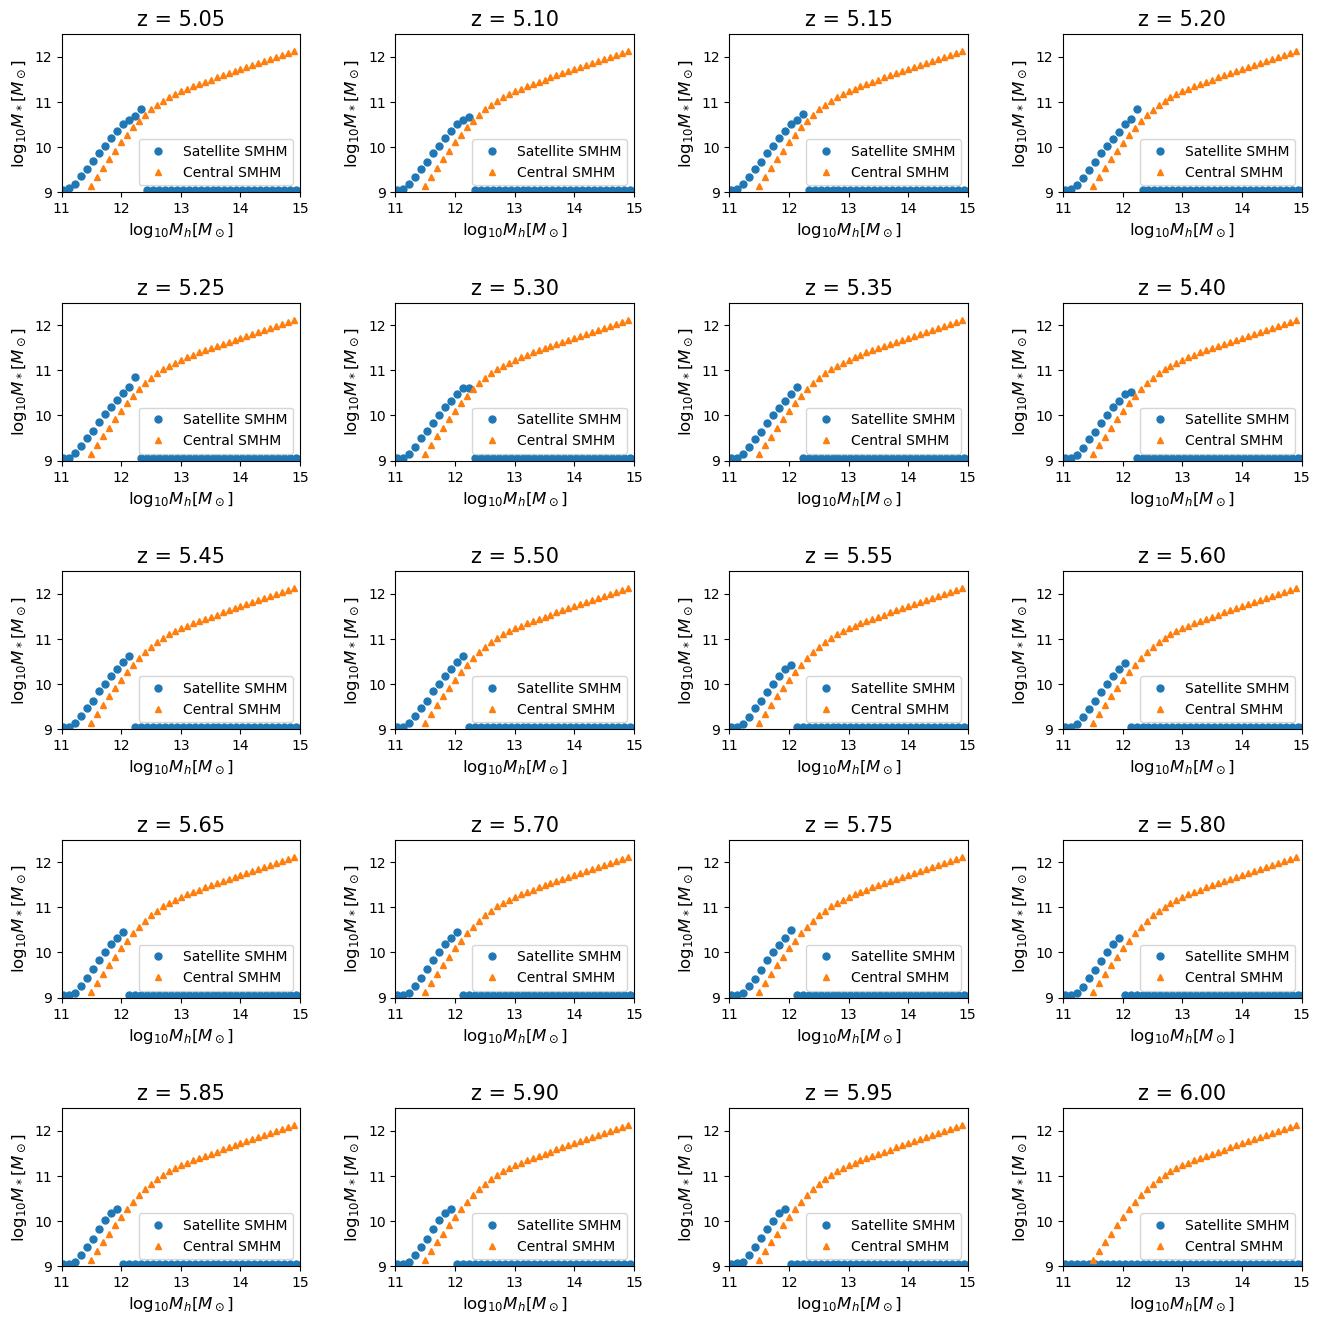

In [173]:
#Plot SMHM relations (Higher resolution 5.5 < 6)

#Initialize some variables
SM, HM, SMHM = SMHM_var_init(Surviving_Sat_SMF_MassRange, SatHaloMass)
z_desired = build_z_desired(z_min=5.05, z_max=6., z_bin=0.05)

N_rows=5
N_cols=4
fig1, ax1 = plt.subplots(N_rows, N_cols, figsize=(16, 16))
plt.subplots_adjust(wspace=0.4, hspace=0.7)
rows_idx=0
cols_idx=0
for z_des in z_desired:
    print('Running z = {:0.2f}'.format(z_des))
    z_idx = identify_idx_z(z_des, z)
    SMHM = np.zeros(SatHaloMass.size+1)
    SMHM = loop_HM_cumu(z_idx, SM, SMHM, SatHaloMass, Sat_SMHM, Num_points=1000)
    #print(SMHM)
    ax1[rows_idx,cols_idx].plot(HM,SMHM, 'o', label='Satellite SMHM')
    ax1[rows_idx,cols_idx].plot(DM, SM_cen[z_idx], '^', label='Central SMHM')
    ax1[rows_idx,cols_idx].set_xlabel(r'log$_{10} M_h [M_\odot]$', fontsize=12)
    ax1[rows_idx,cols_idx].set_ylabel(r'log$_{10} M_* [M_\odot]$', fontsize=12)
    ax1[rows_idx,cols_idx].set_xlim(11,15)
    ax1[rows_idx,cols_idx].set_ylim(9,12.5)
    mpl.rc('xtick', labelsize=10) 
    mpl.rc('ytick', labelsize=10)
    ax1[rows_idx,cols_idx].legend(fontsize=10)
    ax1[rows_idx,cols_idx].set_title('z = {:0.2f}'.format(z_des), fontsize=15)
    if(cols_idx==N_cols-1):
        rows_idx+=1; cols_idx=0
    elif(cols_idx<N_cols-1):
        cols_idx+=1
    '''
    plt.figure()
    plt.plot(HM,SMHM,'o', label='Satellite SMHM')
    plt.plot(DM, SM_cen[z_idx], '^', label='Central SMHM')
    plt.xlabel(r'log$_{10} M_h [M_\odot]$')
    plt.ylabel(r'log$_{10} M_* [M_\odot]$')
    plt.xlim(11,15)
    plt.ylim(9,12.5)
    plt.legend()
    plt.title('z = {}'.format(int(z_des)))
    '''
    
#Clear empty subplot items
for i in range(0, N_rows*N_cols-len(z_desired)):
    ax1[rows_idx,cols_idx].set_visible(False)
    if(cols_idx==N_cols-1):
        rows_idx+=1; cols_idx=0
    elif(cols_idx<N_cols-1):
        cols_idx+=1

plt.savefig(dir_path+'/SMHM_z_HighRes.png', dpi=300)

Running z = 0.0
Running z = 1.0
Running z = 2.0
Running z = 3.0
Running z = 4.0
Running z = 5.0
Running z = 6.0


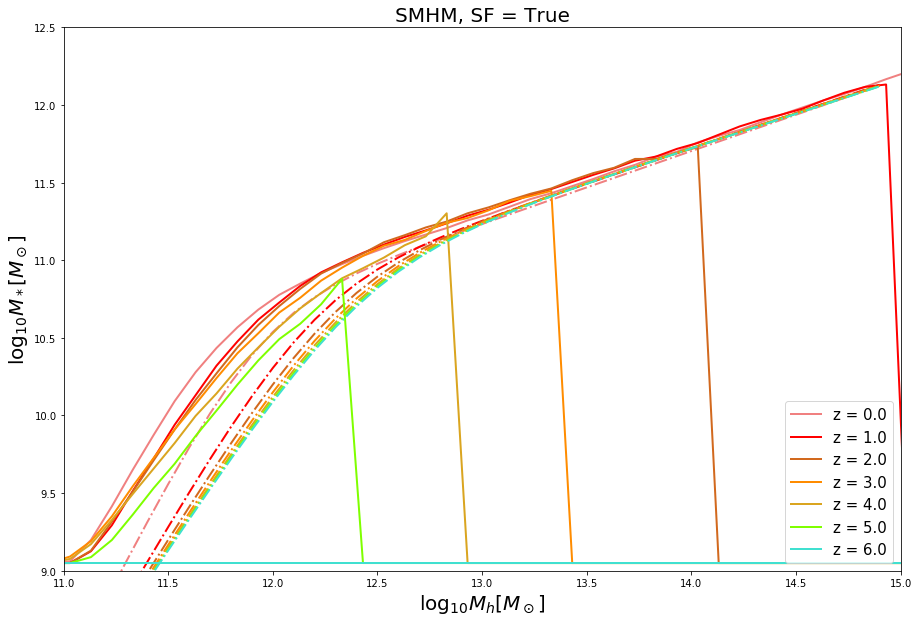

In [9]:
#Plot SMHM in one panel

SM, HM, SMHM = SMHM_var_init(Surviving_Sat_SMF_MassRange, SatHaloMass)
z_desired = build_z_desired(z_min=0., z_max=6., z_bin=1.)

color_map = ['lightcoral', 'red', 'chocolate', 'darkorange', 'goldenrod', 'chartreuse', 'turquoise', 'steelblue', 'slategrey', 'darkviolet', 'plum', 'fuchsia', 'pink']
color_idx = 0
plt.figure(figsize=(15,10))
for z_des in z_desired:
    print('Running z = {:0.1f}'.format(z_des))
    z_idx = identify_idx_z(z_des, z)
    SMHM = np.zeros(SatHaloMass.size+1)
    SMHM = loop_HM_cumu(z_idx, SM, SMHM, SatHaloMass, Sat_SMHM, Num_points=1000)
    plt.plot(HM,SMHM, '-', color = color_map[color_idx], label='z = {:0.1f}'.format(z_des)) #Sat SMHM
    plt.plot(DM, SM_cen[z_idx], '-.', color = color_map[color_idx]) #Central SMHM
    plt.xlabel(r'log$_{10} M_h [M_\odot]$', fontsize=20)
    plt.ylabel(r'log$_{10} M_* [M_\odot]$', fontsize=20)
    plt.xlim(11,15)
    plt.ylim(9,12.5)
    plt.title('SMHM, SF = True', fontsize=20)
    mpl.rc('xtick', labelsize=15) 
    mpl.rc('ytick', labelsize=15)
    plt.legend(loc='lower right', fontsize=15)
    color_idx += 1

plt.savefig(dir_path+'/SMHM_z_1p.png', dpi=300)

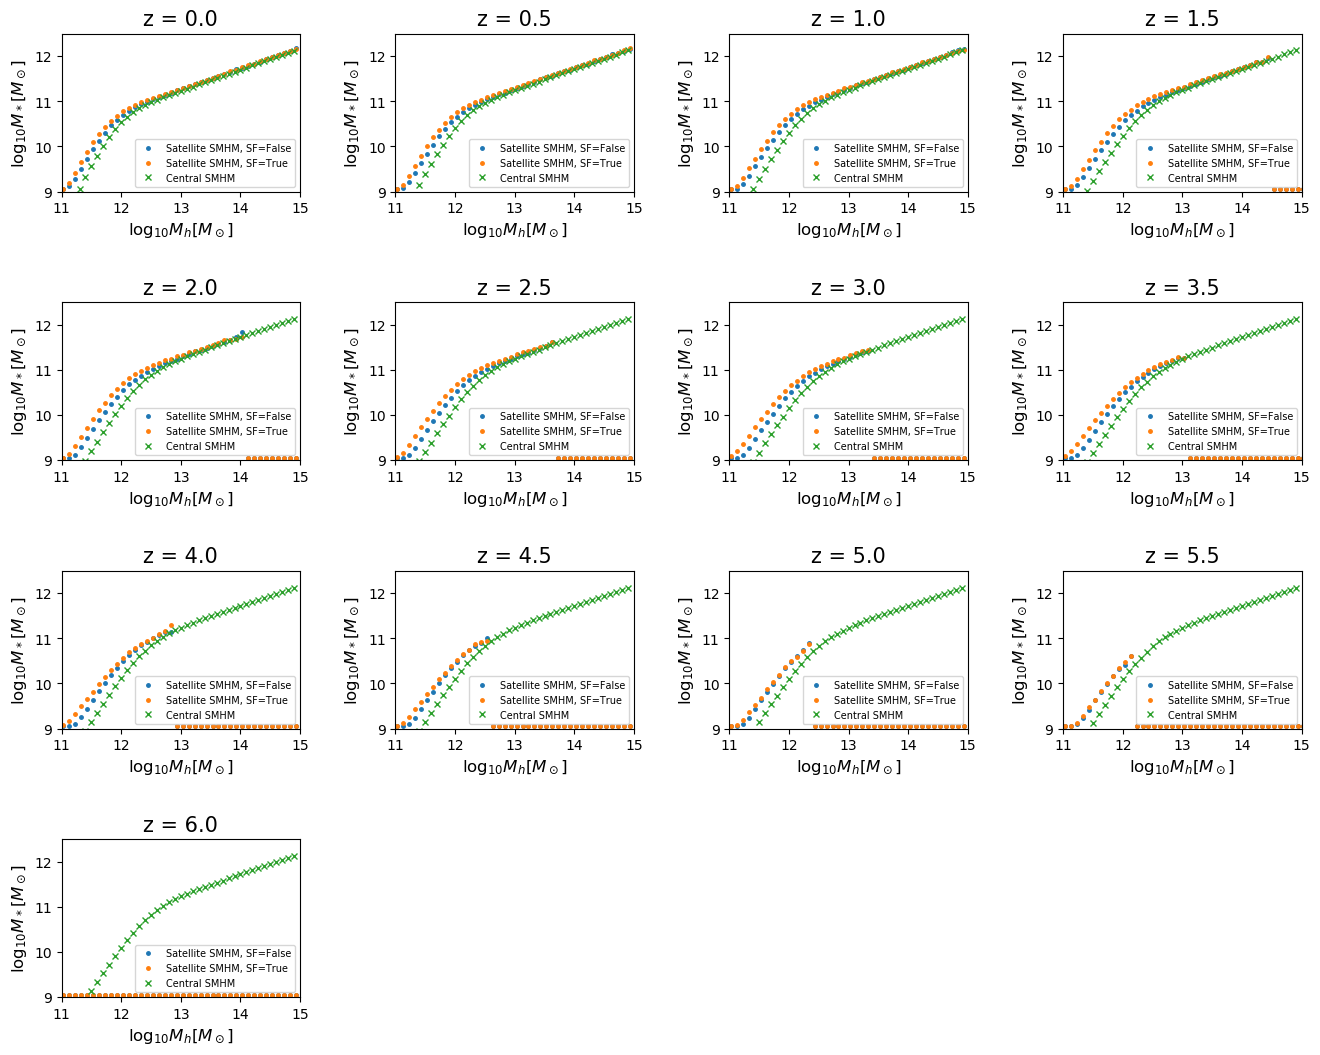

In [187]:
#Compare SMHM of satellites and centrals, with or without Star Formation

Tdyn_Factors = [('1.0', False, False, True, 'CE', 'G19_SE')] #Running parameters
#Tdyn_Factors = [('1.0', True, False, True, 'CE', 'G19_SE')]
#Tdyn_Factors = [('1.0', False, True, True, 'CE', 'G19_SE')]
#Tdyn_Factors = [('1.0', True, True, True, 'CE', 'G19_SE')]

z, SatHaloMass, AvaHaloMass, Surviving_Sat_SMF_MassRange, Sat_SMHM, Sat_SMHM_Host = F.LoadData_Sat_SMHM(Tdyn_Factors)
SM, HM, SMHM = SMHM_var_init(Surviving_Sat_SMF_MassRange, SatHaloMass)
z_desired = build_z_desired(z_min=5.05, z_max=6., z_bin=0.05)

N_rows=5
N_cols=4
fig1, ax1 = plt.subplots(N_rows, N_cols, figsize=(16, 16))
plt.subplots_adjust(wspace=0.4, hspace=0.7)
rows_idx=0
cols_idx=0
z_desired = build_z_desired(z_min=0., z_max=6., z_bin=0.5)
for z_des in z_desired:
    #print('Running SF=False z = {}'.format(z_des))
    z_idx = identify_idx_z(z_des, z)
    SMHM = np.zeros(SatHaloMass.size+1)
    SMHM = loop_HM_cumu(z_idx, SM, SMHM, SatHaloMass, Sat_SMHM, Num_points=1000)
    #print(SMHM)
    ax1[rows_idx,cols_idx].plot(HM,SMHM, '.', label='Satellite SMHM, SF=False')
    #ax1[rows_idx,cols_idx].plot(DM, SM_cen[z_idx], '^', label='Central SMHM')
    if(cols_idx==N_cols-1):
        rows_idx+=1; cols_idx=0
    elif(cols_idx<N_cols-1):
        cols_idx+=1
        

#Tdyn_Factors = [('1.0', False, False, True, 'CE', 'G19_SE')] #Running parameters
#Tdyn_Factors = [('1.0', True, False, True, 'CE', 'G19_SE')]
Tdyn_Factors = [('1.0', False, True, True, 'CE', 'G19_SE')]
#Tdyn_Factors = [('1.0', True, True, True, 'CE', 'G19_SE')]

z, SatHaloMass, AvaHaloMass, Surviving_Sat_SMF_MassRange, Sat_SMHM, Sat_SMHM_Host = F.LoadData_Sat_SMHM(Tdyn_Factors)
SM, HM, SMHM = SMHM_var_init(Surviving_Sat_SMF_MassRange, SatHaloMass)
        
N_rows=5
N_cols=4
#fig1, ax1 = plt.subplots(N_rows, N_cols, figsize=(16, 16))
rows_idx=0
cols_idx=0
for z_des in z_desired:
    #print('Running SF=True z = {}'.format(z_des))
    z_idx = identify_idx_z(z_des, z)
    SMHM = np.zeros(SatHaloMass.size+1)
    SMHM = loop_HM_cumu(z_idx, SM, SMHM, SatHaloMass, Sat_SMHM, Num_points=1000)
    #print(SMHM)
    ax1[rows_idx,cols_idx].plot(HM,SMHM, '.', label='Satellite SMHM, SF=True')
    ax1[rows_idx,cols_idx].plot(DM, SM_cen[z_idx], 'x', label='Central SMHM')
    ax1[rows_idx,cols_idx].set_xlabel(r'log$_{10} M_h [M_\odot]$', fontsize=12)
    ax1[rows_idx,cols_idx].set_ylabel(r'log$_{10} M_* [M_\odot]$', fontsize=12)
    ax1[rows_idx,cols_idx].set_xlim(11,15)
    ax1[rows_idx,cols_idx].set_ylim(9,12.5)
    mpl.rc('xtick', labelsize=10) 
    mpl.rc('ytick', labelsize=10)
    ax1[rows_idx,cols_idx].legend(fontsize=7)
    ax1[rows_idx,cols_idx].set_title('z = {:0.1f}'.format(z_des), fontsize=15)
    if(cols_idx==N_cols-1):
        rows_idx+=1; cols_idx=0
    elif(cols_idx<N_cols-1):
        cols_idx+=1
        
#Clear empty subplot items
for i in range(0, N_rows*N_cols-len(z_desired)):
    ax1[rows_idx,cols_idx].set_visible(False)
    if(cols_idx==N_cols-1):
        rows_idx+=1; cols_idx=0
    elif(cols_idx<N_cols-1):
        cols_idx+=1
        
plt.savefig(dir_path+'/SMHM_z_HighRes_compare.png', dpi=DPI)

In [41]:
print(AvaHaloMass.shape)
print(AnalMod_SMF.shape)
print(Surviving_Sat_SMF_MassRange.shape)
print(z.shape)

(190, 57)
(1, 190, 40)
(40,)
(190,)


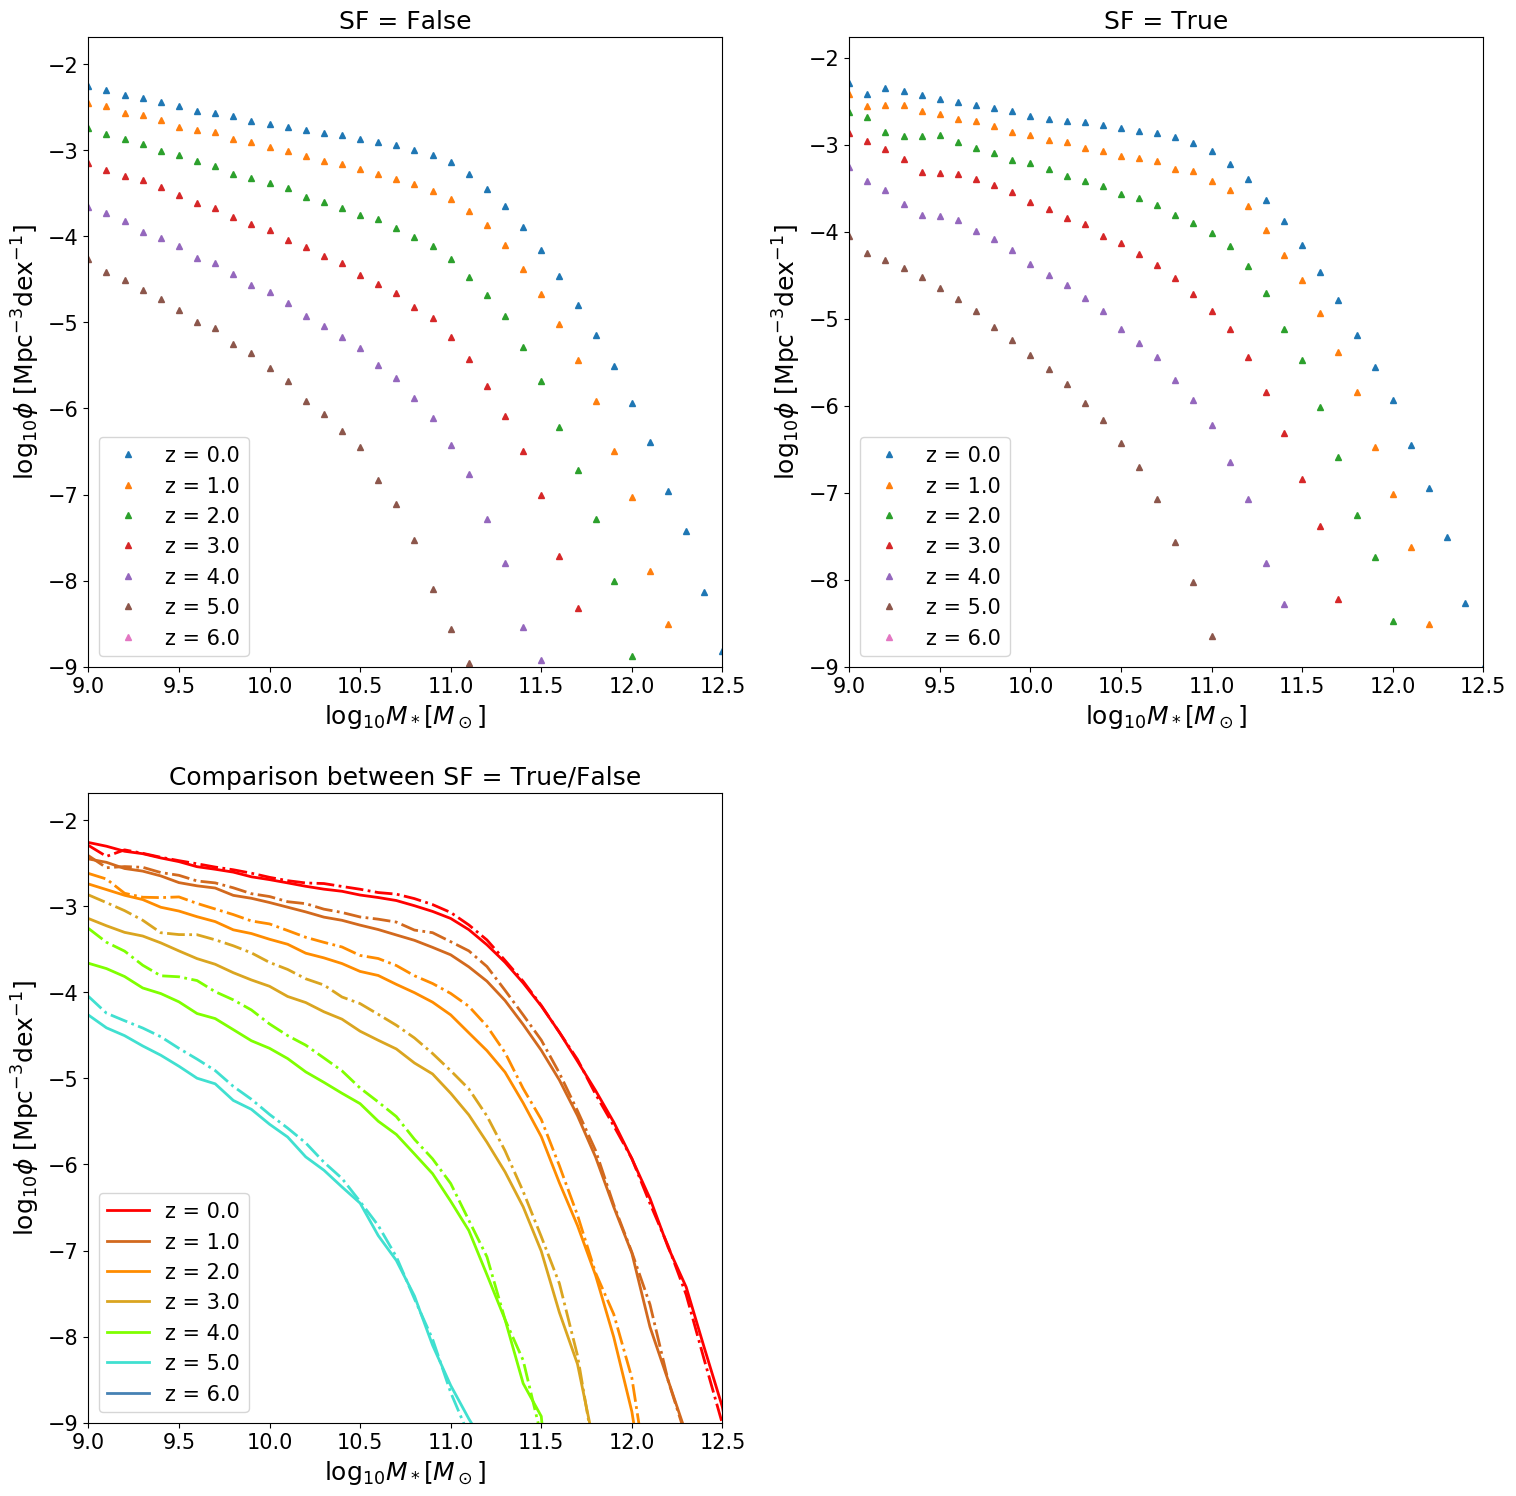

In [227]:
######### Plot Stellar Mass Function SMF

Tdyn_Factors = [('1.0', False, False, True, 'CE', 'G19_SE')] #Running parameters
#Tdyn_Factors = [('1.0', True, False, True, 'CE', 'G19_SE')]
#Tdyn_Factors = [('1.0', False, True, True, 'CE', 'G19_SE')]
#Tdyn_Factors = [('1.0', True, True, True, 'CE', 'G19_SE')]

AvaHaloMass, AnalMod_SMF, Surviving_Sat_SMF_MassRange, z = F.LoadData_SMFhz(Tdyn_Factors)
z_desired = build_z_desired(z_min=0., z_max=6., z_bin=1.)

color_map = ['red', 'chocolate', 'darkorange', 'goldenrod', 'chartreuse', 'turquoise', 'steelblue', 'slategrey', 'darkviolet', 'plum', 'fuchsia', 'pink']
color_idx = 0
fig, ax = plt.subplots(2, 2, figsize=(18, 18))
#plt.subplots_adjust(wspace=0.4, hspace=0.7)
for z_des in z_desired:
    z_idx = identify_idx_z(z_des, z)
    ax[0,0].plot(Surviving_Sat_SMF_MassRange, np.log10(AnalMod_SMF[0,z_idx,:]), '^', label='z = {}'.format(z_des))
    ax[1,0].plot(Surviving_Sat_SMF_MassRange, np.log10(AnalMod_SMF[0,z_idx,:]), '-', color = color_map[color_idx], label='z = {}'.format(z_des))
    color_idx += 1
ax[0,0].legend(loc='lower left')
ax[0,0].set_title('SF = False', fontsize=18)
ax[0,0].set_xlabel(r'log$_{10} M_* [M_\odot]$', fontsize=18)
ax[0,0].set_ylabel(r'log$_{10} \phi$ [Mpc$^{-3}$dex$^{-1}$]', fontsize=18)
ax[0,0].set_xlim(9,12.5)
ax[0,0].set_ylim(-9)

#Tdyn_Factors = [('1.0', False, False, True, 'CE', 'G19_SE')] #Running parameters
#Tdyn_Factors = [('1.0', True, False, True, 'CE', 'G19_SE')]
Tdyn_Factors = [('1.0', False, True, True, 'CE', 'G19_SE')]
#Tdyn_Factors = [('1.0', True, True, True, 'CE', 'G19_SE')]

AvaHaloMass, AnalMod_SMF, Surviving_Sat_SMF_MassRange, z = F.LoadData_SMFhz(Tdyn_Factors)

color_idx = 0
for z_des in z_desired:
    z_idx = identify_idx_z(z_des, z)
    ax[0,1].plot(Surviving_Sat_SMF_MassRange, np.log10(AnalMod_SMF[0,z_idx,:]), '^', label='z = {}'.format(z_des))
    ax[1,0].plot(Surviving_Sat_SMF_MassRange, np.log10(AnalMod_SMF[0,z_idx,:]), '-.', color = color_map[color_idx])
    color_idx += 1
ax[0,1].legend(loc='lower left')
ax[0,1].set_title('SF = True', fontsize=18)
ax[0,1].set_xlabel(r'log$_{10} M_* [M_\odot]$', fontsize=18)
ax[0,1].set_ylabel(r'log$_{10} \phi$ [Mpc$^{-3}$dex$^{-1}$]', fontsize=18)
ax[0,1].set_xlim(9,12.5)
ax[0,1].set_ylim(-9)
ax[1,0].legend(loc='lower left')
ax[1,0].set_title('Comparison between SF = True/False', fontsize=18)
ax[1,0].set_xlabel(r'log$_{10} M_* [M_\odot]$', fontsize=18)
ax[1,0].set_ylabel(r'log$_{10} \phi$ [Mpc$^{-3}$dex$^{-1}$]', fontsize=18)
ax[1,0].set_xlim(9,12.5)
ax[1,0].set_ylim(-9)
mpl.rc('xtick', labelsize=15) 
mpl.rc('ytick', labelsize=15)

#Clear empty subplot items
ax[1,1].set_visible(False)

plt.savefig(dir_path+'/SMF_z.png', dpi=DPI)

(1e-08, 0.02755252319992041)

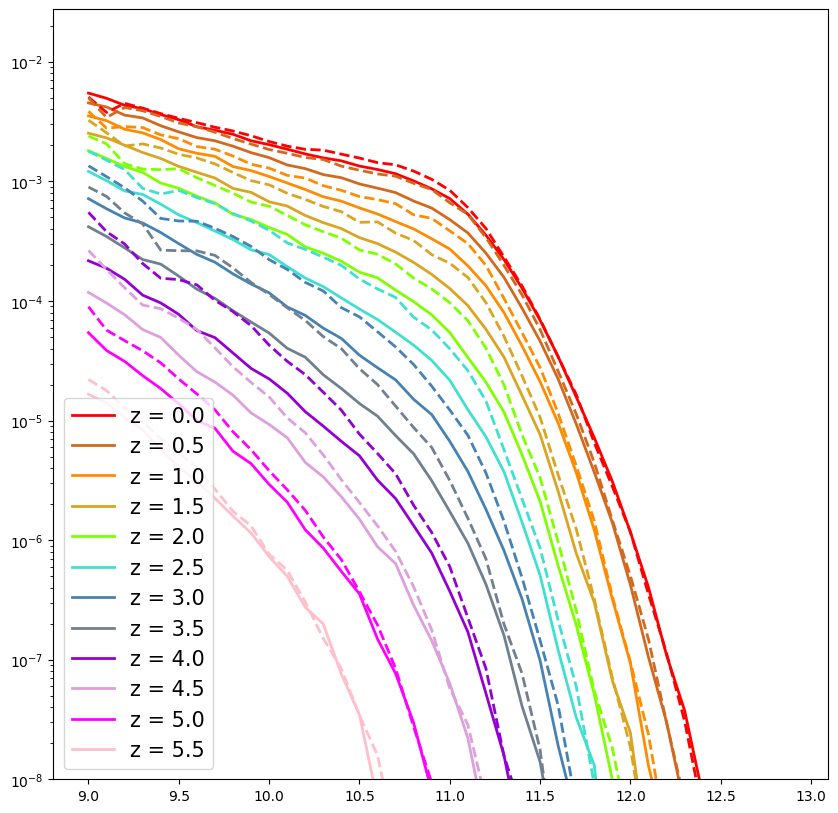

In [164]:
######### Plot Stellar Mass Function SMF

Tdyn_Factors = [('1.0', False, False, True, 'CE', 'G19_SE')] #Running parameters
#Tdyn_Factors = [('1.0', True, False, True, 'CE', 'G19_SE')]
#Tdyn_Factors = [('1.0', False, True, True, 'CE', 'G19_SE')]
#Tdyn_Factors = [('1.0', True, True, True, 'CE', 'G19_SE')]

AvaHaloMass, AnalMod_SMF, Surviving_Sat_SMF_MassRange, z = F.LoadData_SMFhz(Tdyn_Factors)
z_desired = build_z_desired(z_min=0., z_max=6., z_bin=1.)

plt.figure(figsize=(10, 10))
color_map = ['red', 'chocolate', 'darkorange', 'goldenrod', 'chartreuse', 'turquoise', 'steelblue', 'slategrey', 'darkviolet', 'plum', 'fuchsia', 'pink']
color_idx = 0
for z_des in z_desired:
    z_idx = identify_idx_z(z_des, z)
    plt.semilogy(Surviving_Sat_SMF_MassRange, AnalMod_SMF[0,z_idx,:], '-', color = color_map[color_idx], label='z = {}'.format(z_des))
    color_idx += 1
plt.legend(loc='lower left')


#Tdyn_Factors = [('1.0', False, False, True, 'CE', 'G19_SE')] #Running parameters
#Tdyn_Factors = [('1.0', True, False, True, 'CE', 'G19_SE')]
Tdyn_Factors = [('1.0', False, True, True, 'CE', 'G19_SE')]
#Tdyn_Factors = [('1.0', True, True, True, 'CE', 'G19_SE')]

AvaHaloMass, AnalMod_SMF, Surviving_Sat_SMF_MassRange, z = F.LoadData_SMFhz(Tdyn_Factors)

color_idx = 0
for z_des in z_desired:
    z_idx = identify_idx_z(z_des, z)
    plt.semilogy(Surviving_Sat_SMF_MassRange, AnalMod_SMF[0,z_idx,:], '--', color = color_map[color_idx])
    color_idx += 1
    
plt.ylim(1.e-8)

Running z = 0.1


ValueError: x and y must have same first dimension, but have shapes (1,) and (66,)

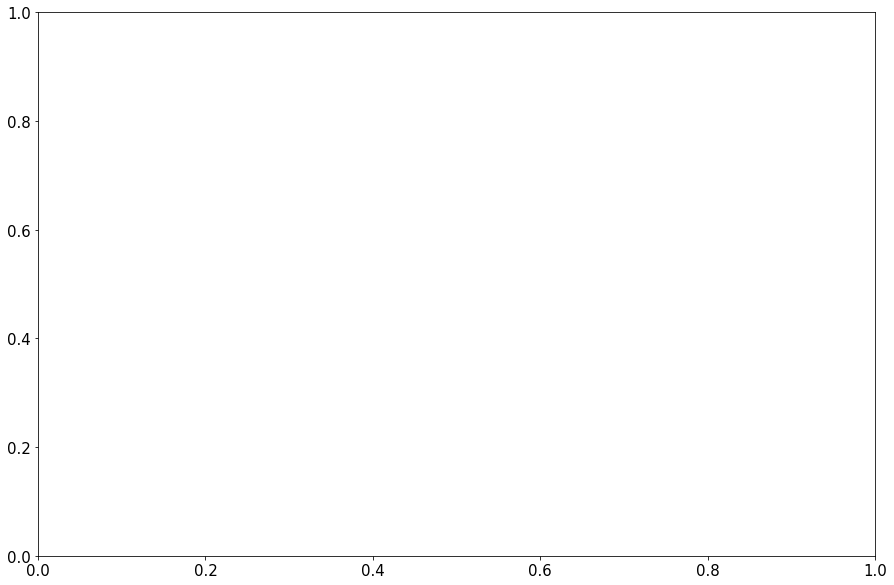

In [39]:
#### Plot SM(z)

#Tdyn_Factors = [('1.0', False, False, True, 'CE', 'G19_SE')] #Running parameters
#Tdyn_Factors = [('1.0', True, False, True, 'CE', 'G19_SE')]
Tdyn_Factors = [('1.0', False, True, True, 'CE', 'G19_SE')]
#Tdyn_Factors = [('1.0', True, True, True, 'CE', 'G19_SE')]

z, SatHaloMass, AvaHaloMass, Surviving_Sat_SMF_MassRange, Sat_SMHM, Sat_SMHM_Host = F.LoadData_Sat_SMHM(Tdyn_Factors)
SM, HM, SMHM = SMHM_var_init(Surviving_Sat_SMF_MassRange, SatHaloMass)
z_desired = build_z_desired(z_min=0.1, z_max=4., z_bin=0.1)


plt.figure(figsize=(15,10))
for z_des in z_desired:
    print('Running z = {:0.1f}'.format(z_des))
    z_idx = identify_idx_z(z_des, z)
    SMHM = np.zeros(SatHaloMass.size+1)
    SMHM = loop_HM_cumu(z_idx, SM, SMHM, SatHaloMass, Sat_SMHM, Num_points=10)
    plt.plot(z_des,SMHM, '-')
    plt.xlabel(r'log$_{10} M_h [M_\odot]$', fontsize=20)
    plt.ylabel(r'log$_{10} M_* [M_\odot]$', fontsize=20)
    plt.xlim(0.1,4)
    plt.ylim(9.5,11.5)
    plt.title('Stellar Mass (z)', fontsize=20)
    mpl.rc('xtick', labelsize=15) 
    mpl.rc('ytick', labelsize=15)
    plt.legend(loc='lower right', fontsize=15)

plt.savefig(dir_path+'/Plot_SM(z).png', dpi=300)